In [1]:
import jax.numpy as jnp
import numpy as np
import jax.random as jrandom
from jax import jit, grad, jacfwd

import sys 
import os 
HOME = os.getenv("HOME")
sys.path.append(HOME + "/curr_adventure/exact_sampling/")
sys.path.append(HOME + "/curr_adventure/exact_sampling/Optimization")

# from Optimization import NewtonMethod
# from pdfo import newuoa

# from NEWUO_test import NEWUOA_Wrapper

# from pow_sampling_set import pow_SG
# from Functions import PyCutestGetter, load_cutest_quadratic, HeartDisease
# from AdaptiveFD import adapt_FD
# from FD import FD

import sys
sys.path.append("/Users/daniellengyel/curr_adventure/exact_sampling/Ours")
from pow_sampling_set import create_approx_S

from tqdm import tqdm

import matplotlib.pyplot as plt

import scipy

%load_ext autoreload
%autoreload 2

In [2]:
def loss_getter(dim, D, sig):
    def helper(X):
        S = X.reshape(dim, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ D @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        
        return 1/4 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)
    return helper

def lmbda_loss(lmbdas, D_diag, sig, l_max_idx):
    dim = len(D_diag)

    a = D_diag @ lmbdas / len(lmbdas)
#     print(repr(lmbdas))
    return 1/4. * a**2 * dim / lmbdas[l_max_idx] + sig**2 * dim/lmbdas[l_max_idx] + sig**2 * jnp.sum(1/lmbdas)


In [3]:
dim = 502
# l_max_idx = dim - 1
jrandom_key = jrandom.PRNGKey(0)
D_diag = 1000*(jrandom.uniform(jrandom_key, shape=(dim,)) - 1/2.)*2 # jnp.linspace(-51065, 10, dim)
dim = len(D_diag)
l_max_idx = 0# dim - 1
x0 = jnp.ones(dim) * l_max




NameError: name 'l_max' is not defined

In [402]:
grad_lmbda_loss = grad(lambda x: lmbda_loss(x, D_diag, sig, l_max_idx))
hess_lmbda_loss = jacfwd(lambda x: grad_lmbda_loss(x))

In [403]:
sig = .135
l_max = 245

In [19]:
def grad_lmbda_loss_analytic(lmbdas, D_diag, sig, l_max_idx):
    dim = len(lmbdas)
    D_diag = jnp.array(D_diag)
    a = D_diag @ lmbdas / len(lmbdas)
    grad = 1/2. * a * D_diag / lmbdas[l_max_idx] - sig**2 / lmbdas**2
    grad = grad.at[l_max_idx].add(-1/4. * a**2 * dim / lmbdas[l_max_idx]**2 - sig**2 * dim / lmbdas[l_max_idx]**2)
    return jnp.array(grad)

In [350]:
grad_lmbda_loss_analytic(res["x"], D_diag, sig, l_max_idx)

DeviceArray([-2.41625355e-06, -2.74576237e-08, -8.55595531e-07,
             -1.49130954e-06, -9.29952340e-02], dtype=float64)

In [519]:
jnp.sum(D_diag)

DeviceArray(245933.7755102, dtype=float64)

In [465]:
factor = l_max * np.sum(D_diag[np.array(D_diag > 0)]) / np.abs(np.sum(D_diag[np.array(D_diag < 0)]))
factor

23734.56186942714

In [467]:
l = np.ones(dim) * l_max 
l[np.array(D_diag) < 0] = factor
fun(l)

DeviceArray(4.457779e-05, dtype=float64)

In [13]:
def compute_lmbda_indefinite_hess(D_diag, sig, l_max, tol=1e-6):


    dim = len(D_diag)
    D_diag_sum = jnp.sum(D_diag)

    if D_diag_sum > 0:
        D_diag_use = -D_diag
    else:
        D_diag_use = D_diag

    k = 1/dim * jnp.sum(D_diag_use[D_diag_use >= 0]) * l_max
    c = 1/dim * jnp.sqrt(2 * l_max) * sig * jnp.sum(jnp.sqrt(-D_diag_use[D_diag_use < 0])) 
    cbrt_term = jnp.cbrt(27 * c**2 + 2 * k**3 + 3 * jnp.sqrt(81*c**4 + 12 * c**2 * k**3))

    a = -(1/3. * (-2*k + jnp.cbrt(2) * k**2 / cbrt_term + cbrt_term/jnp.cbrt(2)))
    lmbda = np.ones(dim) * float(l_max) 
    
    # ensures that no lmbda is larger than l_max. TODO check further what this even implies. I think essentially
    # that we are then just minimizing sum_i 1/lambda_i^2 such that a = 0. 
    # Which should happen when all have the same value. 
    if abs(a) <= max(tol, 2 * sig**2 / (np.min(np.abs(D_diag_use)) * l_max)):
        print(a)
        lmbda[np.array(D_diag_use) < 0] = l_max * np.sum(D_diag_use[np.array(D_diag_use > 0)]) / np.abs(np.sum(D_diag_use[np.array(D_diag_use < 0)]))
    else:
        lmbda[np.array(D_diag_use < 0)] = sig * jnp.sqrt(2 * l_max / (a * D_diag_use[D_diag_use < 0]))
    
    return jnp.array(lmbda)
    

In [14]:
D_diag = jnp.linspace(-10, 5, 10)
sig = 1 
l_max = 1

compute_lmbda_indefinite_hess(D_diag, sig, l_max)

DeviceArray([4.49741537e-01, 4.92667169e-01, 5.50818641e-01,
             6.36030581e-01, 7.78975192e-01, 1.10163728e+00,
             5.51038901e+07, 1.00000000e+00, 1.00000000e+00,
             1.00000000e+00], dtype=float64)

In [23]:
l_max_idx = dim - 1
print(l_max_idx)
# l_max = 1e5
dim = len(D_diag)
x0 = jnp.ones(len(D_diag))
fun = lambda x: lmbda_loss(x, D_diag, sig, l_max_idx)
res = scipy.optimize.minimize(fun, x0, bounds=[(1e-3, l_max)]*dim)
print(res)
print(D_diag)
# res["x"][-jnp.sum(D_diag > 0):]

9
      fun: DeviceArray(26.28562551, dtype=float64)
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.84217094e-06, -1.10134124e-05, -2.06057392e-05,  1.63424828e-05,
        3.55271366e-06, -1.83364789e-01, -1.00000008e+00, -1.81663537e+00,
       -2.63327065e+00, -1.58507215e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 154
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.45176276, 0.49488049, 0.5532922 , 0.63889091, 0.78247663,
       1.        , 1.        , 1.        , 1.        , 1.        ])
[-1.00000000e+01 -8.33333333e+00 -6.66666667e+00 -5.00000000e+00
 -3.33333333e+00 -1.66666667e+00 -6.66133815e-16  1.66666667e+00
  3.33333333e+00  5.00000000e+00]


In [547]:
D_diag = np.linspace(1, 10000)
D_diag[:5] *= -1

In [553]:
compute_lmbda_indefinite_hess(D_diag, sig, 1e5)

DeviceArray([ 96416.24235226,  96416.24235226,  96416.24235226,
              96416.24235226,  96416.24235226,  96416.24235226,
              96416.24235226,  96416.24235226, 100000.        ,
             100000.        , 100000.        , 100000.        ,
             100000.        , 100000.        ,  96416.24235226,
             100000.        , 100000.        , 100000.        ,
             100000.        ,  96416.24235226,  96416.24235226,
             100000.        ,  96416.24235226, 100000.        ,
             100000.        , 100000.        , 100000.        ,
             100000.        , 100000.        , 100000.        ,
             100000.        ,  96416.24235226, 100000.        ,
             100000.        ,  96416.24235226,  96416.24235226,
              96416.24235226,  96416.24235226,  96416.24235226,
              96416.24235226,  96416.24235226, 100000.        ,
             100000.        , 100000.        , 100000.        ,
             100000.        ,  96416.242

In [554]:
fun(compute_lmbda_indefinite_hess(D_diag, sig, 1e5))

DeviceArray(0.00018813, dtype=float64)

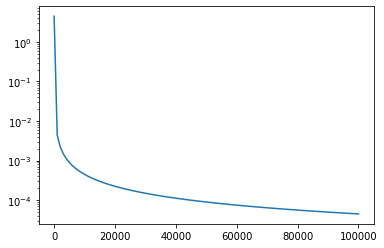

In [504]:
res_f = []
for l_max in jnp.linspace(1, 1e5, 100):
    res_f.append(fun(compute_lmbda_indefinite_hess(D_diag, sig, l_max)))
    
plt.plot(jnp.linspace(1, 1e5, 100), res_f)
plt.yscale("log")

In [428]:
lambda_coeff_zero(jnp.abs(D_diag), sig)

DeviceArray([4.23276493e-03, 4.23699641e-03, 4.24124061e-03,
             4.24549758e-03, 4.24976740e-03, 4.25405013e-03,
             4.25834584e-03, 4.26265458e-03, 4.26697643e-03,
             4.27131145e-03, 4.27565971e-03, 4.28002127e-03,
             4.28439622e-03, 4.28878460e-03, 4.29318650e-03,
             4.29760198e-03, 4.30203111e-03, 4.30647396e-03,
             4.31093061e-03, 4.31540112e-03, 4.31988557e-03,
             4.32438403e-03, 4.32889657e-03, 4.33342327e-03,
             4.33796420e-03, 4.34251943e-03, 4.34708904e-03,
             4.35167311e-03, 4.35627171e-03, 4.36088492e-03,
             4.36551282e-03, 4.37015548e-03, 4.37481299e-03,
             4.37948542e-03, 4.38417286e-03, 4.38887537e-03,
             4.39359305e-03, 4.39832598e-03, 4.40307424e-03,
             4.40783790e-03, 4.41261706e-03, 4.41741181e-03,
             4.42222221e-03, 4.42704836e-03, 4.43189035e-03,
             4.43674827e-03, 4.44162219e-03, 4.44651221e-03,
             4.45141841e

In [420]:
fun(compute_lmbda_indefinite_hess(D_diag, sig, l_max))

DeviceArray(5011.85417274, dtype=float64)

In [400]:
fun(jnp.array([1.56362948e-02, 1.80554695e-02, 2.21148112e-02, 3.12795882e-02,
       2.44997180e+02]))

DeviceArray(3.58476061, dtype=float64)

In [353]:
1/0.38138702**2

6.874928460915464

In [411]:
D_diag @ res["x"] / dim


DeviceArray(-55.50487435, dtype=float64)

In [55]:
def lambda_coeff_zero(D_diag, sig):
    dim = len(D_diag)
    D_diag = jnp.abs(D_diag)
    D_min = jnp.min(D_diag)
    D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_min)
    numerator = 2 * (1 + dim) * D_min * sig**2 + D_sum**2 * sig**2 + jnp.sqrt(D_sum**2 * (8 * (1 + dim) * D_min + D_sum**2) * sig**4)
    
    a = jnp.sqrt(2 * numerator/(dim * D_min))
    l = (2 * (1 + dim) * D_min * sig**2 + numerator)/(D_min**2 * a)

    lmbdas = [(sig * jnp.sqrt(2*l/(D_diag[i] * a))) for i in range(len(D_diag))]
    lmbdas[jnp.argmin(jnp.abs(D_diag))] = l
    
    return jnp.array(lmbdas)

In [56]:
def lambda_coeff_zero_set_max_lambda(D_diag, l_max, sig):
    dim = len(D_diag)
    D_diag = jnp.abs(D_diag)
    D_min = jnp.min(D_diag)
    D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_min)

    sqrt_term = 3 * jnp.sqrt(3 * dim) * jnp.sqrt(27 * dim * D_sum**4 * l_max**2 * sig**4 - 2 * D_min**3 * D_sum**2 * l_max**4 * sig**2)
    cbrt_term = jnp.cbrt(sqrt_term + 27 * dim * D_sum**2 * l_max * sig**2 - D_min**3 * l_max**3)/dim

    a = (dim * cbrt_term + D_min * l_max)**2 / (3 * dim**2 * cbrt_term)
    
    lmbdas = []
    for i in range(len(D_diag)):
        if D_diag[i] != 0:
            lmbdas.append(min(sig * jnp.sqrt(2*l_max/(D_diag[i] * a)), l_max))
        else:
            lmbdas.append(l_max)
        
    lmbdas[jnp.argmin(D_diag)] = l_max
    
    return jnp.array(lmbdas)

In [72]:
def new_lambda_coeff_zero_set_max_lambda(D_diag, sig, l_max):


    dim = len(D_diag)
    
    bool_filter = np.zeros(dim) == 0
    
    lmbda = lambda_coeff_zero(D_diag, sig)
    if (l_max is None) or all(lmbda <= l_max):
        return lmbda 
    
    bool_filter[np.argmax(lmbda)] = 0
    
    def helper(k, c):
        cbrt_term = jnp.cbrt(27 * c**2 - 2 * k**3 + 3 * jnp.sqrt(81*c**4 - 12 * c**2 * k**3))
        a = (1/3. * (2*k + jnp.cbrt(2) * k**2 / cbrt_term + cbrt_term/jnp.cbrt(2)))
        return a
    
    while True:
        k = 1/dim * jnp.sum(D_diag[~bool_filter]) * l_max
        c = 1/dim * jnp.sqrt(2 * l_max) * sig * jnp.sum(jnp.sqrt(D_diag[bool_filter])) 
        a = helper(k, c)
        lmbda = np.ones(dim) * float(l_max) 
        lmbda[bool_filter] = sig * jnp.sqrt(2 * l_max / (a * D_diag[bool_filter]))
        print(lmbda)
        print(l_max)
        print()
        if any(lmbda > l_max):
            bool_filter[np.argmax(lmbda)] = 0
        else:
            break
        
    
    return jnp.array(lmbda)
    

In [29]:
new_lambda_coeff_zero_set_max_lambda(D_diag, sig, l_max)

DeviceArray([1.        , 1.        , 1.        , 0.87229565, 0.59428811,
             0.40488377, 0.2758441 , 0.1879304 , 0.12803549, 0.08722956],            dtype=float64)

In [67]:
D_diag = jnp.linspace(-4, 20, 4)
l_max = 1
sig = 20
dim = len(D_diag)
l = loss_getter(dim, jnp.diag(D_diag), sig)

In [55]:
import time

In [56]:
start_time = time.time()
lambda1 = new_lambda_coeff_zero_set_max_lambda(D_diag, l_max, sig)
print(time.time() - start_time)
start_time = time.time()
lambda2 = lambda_coeff_zero_set_max_lambda(D_diag, l_max, sig)
print(time.time() - start_time)

0.3471097946166992
0.21743297576904297


In [50]:
lmbda_loss(lambda1, D_diag, sig, 0)

DeviceArray(903.07398274, dtype=float64)

In [51]:
lmbda_loss(lambda2, D_diag, sig, 0)

DeviceArray(903.08549946, dtype=float64)

In [76]:
D_diag = jnp.linspace(1, 1e5, 10)

In [77]:
new_lambda_coeff_zero_set_max_lambda(D_diag, 3**2, sig)**0.5

[2.00000000e+01 2.38339395e-02 1.68535194e-02 1.37609442e-02
 1.19173720e-02 1.06592455e-02 9.73052994e-03 9.00872986e-03
 8.42690192e-03 7.94496429e-03]
20



DeviceArray([4.47213595, 0.15438245, 0.12982111, 0.11730705, 0.10916672,
             0.10324362, 0.09864345, 0.09491433, 0.09179816, 0.08913453],            dtype=float64)

In [80]:
D_diag = np.linspace(1, 1e5, 10)
D_diag[0] = 100
new_lambda_coeff_zero_set_max_lambda(D_diag, 3**2, sig)**0.5

[2.00000000e+01 2.11273369e-02 1.49396193e-02 1.21982396e-02
 1.05640250e-02 9.44877245e-03 8.62552262e-03 7.98569077e-03
 7.46993572e-03 7.04272734e-03]
20



DeviceArray([4.47213595, 0.14535246, 0.12222774, 0.11044564, 0.10278144,
             0.0972048 , 0.09287369, 0.08936269, 0.08642879, 0.08392096],            dtype=float64)

In [47]:
S_curr = create_approx_S(jnp.diag(D_diag), sig, 100)

In [48]:
l(S_curr.T.flatten())

DeviceArray(0.00296822, dtype=float64)

In [50]:
jnp.sqrt(S_curr.T @ S_curr)

DeviceArray([[59.31928888, 45.41230292, 49.87623934, 43.94662056],
             [45.41230292, 59.31928888, 43.94662056, 49.87623934],
             [49.87623934, 43.94662056, 59.31928888, 45.41230292],
             [43.94662056, 49.87623934, 45.41230292, 59.31928888]],            dtype=float64)